<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from datetime import datetime
from Data_processor import YahooFinanceProcessor

### Download Data

In [2]:
# 設定資料日期範圍
TRAIN_START_DATE = "2020-01-01"
TRAIN_END_DATE = "2021-12-31"

TEST_START_DATE = "2022-01-01"
TEST_END_DATE = "2022-12-31"

### Data Preprocessing

In [3]:
# 資料下載與前處理(只包含training範圍的資料)

# 股票代碼與技術指標的list
ticker_list = ['jpm','mcd','wmt','pg','unh','aapl','nke','vz','dis','jnj']
# ticker_list =['VTV','VUG','VIG','USMV','QUAL']
tech_list = []

# 技術指標與VIX的開關，如果不想加就設定為False
if_vix = False
if_tech = True

# 下載並清洗資料
DP = YahooFinanceProcessor()
train_data = DP.download_data(start_date = TRAIN_START_DATE,end_date = TRAIN_END_DATE,ticker_list = ticker_list, time_interval='1D')
train_data = DP.clean_data(train_data)
test_data = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ticker_list, time_interval='1D')
test_data = DP.clean_data(test_data)

# 加入技術指標和恐慌指數(如果有的話)
if if_tech:
    tech_list = ['close_30_sma','close_60_sma','macd','boll_ub','boll_lb','dx_30','rsi_30']
    train_data = DP.add_technical_indicator(train_data, tech_list)
    test_data = DP.add_technical_indicator(test_data, tech_list)
    
if if_vix:
    train_data = DP.add_vix(train_data)
    test_data = DP.add_vix(test_data)
    
# DataFrame轉成np.array
price_array_train, tech_array_train, turbulence_array_train = DP.df_to_array(train_data,tech_list, if_vix, if_tech)
price_array_test, tech_array_test, turbulence_array_test = DP.df_to_array(test_data,tech_list, if_vix, if_tech)

# 加入額外的state資訊 ( RN embedding )
aug_state_array_train = np.zeros((0,0))
aug_state_array_test = np.zeros((0,0))
# aug_state_array = np.zeros((price_array.shape[0],11,8)) # (754,11,8)



# 印一下形狀
print('=============')
print('price_array_train: ',price_array_train.shape)
print('tech_array_train: ',tech_array_train.shape)
print('turbulence_array_train: ',turbulence_array_train.shape)
print('aug_state_array_train: ',aug_state_array_train.shape)
print('-----------')
print('price_array_test: ',price_array_test.shape)
print('tech_array_test: ',tech_array_test.shape)
print('turbulence_array_test: ',turbulence_array_test.shape)
print('aug_state_array_test: ',aug_state_array_test.shape)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5040, 9)
Clean data for aapl
Data clean for aapl is finished.
Clean data for dis
Data clean for dis is finished.
Clean data for jnj
Data clean for jnj is finished.
Clean data for jpm
Data clean for jpm is finished.
Clean data for mcd
Data clean for mcd is finished.
Clean data for nke
Dat

## Initiate Agent & Environment 

In [4]:
# 金融交易環境for資產配置
class StockPortfolioEnv:  
    
    # 初始化參數由env_args傳入
    def __init__(self, 
                 price_array, #各公司的股價(調整後收盤價)
                 tech_array, #技術指標陣列
                 aug_state_array, #其他的state(embedding / 時間資訊 / 資產資訊)
                 env_name, #環境名稱
                 lookback, #window size(每次交易看過去幾天) 
                ):
        
        initial_capital = 100000
        
        self.lookback = lookback  # 預設看過去10天
        self.initial_total_asset = initial_capital # 初始總資產(股票+現金)
        self.initial_cash = initial_capital #初始現金
        
        self.trans_cost = 0.01 #交易手續費(買賣都一樣)
        self.buy_cost_pct = self.trans_cost # buy手續費
        self.sell_cost_pct = self.trans_cost # sell手續費
        self.gamma = 1 # reward遞減係數
        
        # 載入放入state的陣列
        self.price_array = price_array 
        self.tech_array = tech_array  
        self.aug_state_array = aug_state_array        
        
        # 價格轉成daily return 
        self.price_return = pd.DataFrame(self.price_array).pct_change(1).fillna(0).values

        
        self.stock_num = self.price_array.shape[1] #有幾隻股票要交易
        self.max_step =  self.price_array.shape[0] - lookback -1 #每個episode最多走幾步(期初走到最後一天)
        self.env_num = 1 #有幾個環境(預設為1)
        
        # 將環境初始化
        self.time = lookback-1 #現在的時間點
        self.cash = self.initial_cash
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time] if self.tech_array.shape[0]>0 else self.tech_array
        self.current_aug_state = self.aug_state_array[self.time] if self.aug_state_array.shape[0]>0 else self.aug_state_array
        self.portfolio = np.zeros(self.stock_num, dtype=np.float32) #現在手上的股票部位
        
        # 紀錄訓練的結果
        self.history = {'cumu_return':[],'action':[]}

        # 紀錄現有資產及報酬率
        self.total_asset = self.cash + (self.portfolio * self.price_array[self.time]).sum()
        self.episode_return = 0.0  
        self.gamma_return = 0.0
        

        '''env information'''
        self.env_name = env_name
        # self.state_dim = self.price_return.shape[1]*lookback 
        self.state_dim = (self.price_array.shape[1] + self.tech_array.shape[1])*lookback
        self.action_dim = self.price_return.shape[1]+1 #加一維cash
        self.mid_dim = 16 #過完CNN每家公司的embedding長度  
        self.aug_state_dim = 1
        #self.current_working_dir = current_working_dir
        

        self.if_discrete = False
        self.target_return = 10
        self.total_cumulative_return = []
        
    # softmax
    def action_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        
        return softmax_output

    def reset(self) -> np.ndarray:
        self.time = self.lookback-1
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time] if self.tech_array.shape[0]>0 else self.tech_array
        self.current_aug_state = self.aug_state_array[self.time] if self.aug_state_array.shape[0]>0 else self.aug_state_array
        self.cash = self.initial_cash  # reset()
        self.portfolio = np.zeros(self.stock_num, dtype=np.float32) # 持有股數
        self.total_asset = self.cash + np.sum(self.portfolio * self.price_array[self.time]) # 總資產價值
        self.history = {'cumu_return':[],'action':[],'total_asset':[],'episode return':[]}
        self.episode_return = 0.0
        self.gamma_return = 0.0
        state  = self.get_state()
        
        return state

    
    def step(self, actions) -> (np.ndarray, float, bool, None):
        self.time += 1
        #print('time:',self.time)
        """transaction"""
        # 隔一天的weight，包含股票及現金的持有比例
        action = self.action_normalization(actions)
        action = action.reshape(-1)
        
        # 新的持有股數：現在的weight*前一天總資產價值/股價(無條件捨去)
        new_portfolio = np.floor(action[:-1]*self.total_asset/self.price_array[self.time-1])
        
        # 前一天配置股票剩餘資金納入手上現金部位
        self.cash = self.total_asset - sum(new_portfolio*self.price_array[self.time-1])
        
        # 計算手續費
        portfolio_change = np.sum((new_portfolio-self.portfolio)*self.price_array[self.time-1])
        trans_cost = portfolio_change*self.trans_cost
        self.cash-=trans_cost
        
        # 計算新的資產價值
        new_total_asset = np.sum(new_portfolio*self.price_array[self.time])+self.cash
        #print('cash',self.cash)
        
        # 計算報酬率
        portfolio_return = new_total_asset/self.total_asset
        self.cumu_return = new_total_asset/self.initial_total_asset
        reward = (portfolio_return-1)*100
        
        #更新資產狀態
        self.total_asset = new_total_asset
        self.portfolio = new_portfolio
        
        self.gamma_return = self.gamma_return * self.gamma + reward 
        self.cumu_return = self.total_asset / self.initial_cash
        
        self.history['cumu_return'].append(self.cumu_return)
        self.history['action'].append(action)
        self.history['total_asset'].append(self.total_asset)
                
        """update time"""
        done = self.time == self.max_step+self.lookback
        state = self.get_state()
        self.episode_return = self.total_asset / self.initial_total_asset
        if done:
            #print('self.max_step',self.max_step)
            reward = self.gamma_return
            self.episode_return = self.total_asset / self.initial_total_asset
            
            ''' 
            # 畫圖
            plt.plot(self.history['cumu_return'])
            plt.savefig('./train_history/cumulative_return/cumulative_plot'+datetime.now().strftime('%Y-%m-%d %H:%M:%S')+'.png')
            plt.close()
            '''
            
            # 每個episode交易紀錄存檔
            pd.DataFrame(self.history['cumu_return']).to_csv('./train_history/cumulative_return/cumu_return'\
                                                             +datetime.now().strftime('%Y-%m-%d %H:%M:%S')+'.csv')
            pd.DataFrame(self.history['action']).to_csv('./train_history/action/action'\
                                                             +datetime.now().strftime('%Y-%m-%d %H:%M:%S')+'.csv')
        return state, reward, done, None

    def get_state(self):
        # 從現在時間往前取n天(lookback)
        state = self.price_return[self.time-self.lookback+1:self.time+1].reshape(-1)*100 #flatten
        if self.aug_state_array.shape[0]!=0: #如果有aug_state的話
            state = np.concatenate(state,self.aug_state_array[self.time])

        if self.tech_array.shape[0]!=0: #如果有tech_array的話
            for i in range(self.lookback):
                tech_i = self.tech_array[self.time-i]
                normalized_tech_i = tech_i * 2 ** -15
                state = np.hstack((state, normalized_tech_i)).astype(np.float32)

        
        
            
        return state

### Create Folder

In [5]:
# 清空資料夾
import shutil
import os
if os.path.exists('./train_history'):
    shutil.rmtree('./train_history')
if os.path.exists('./portfolio_allocation_PPO_0'):
    shutil.rmtree('./portfolio_allocation_PPO_0')
if not os.path.exists("./" + 'train_history'):
    os.makedirs("./" + 'train_history')
if not os.path.exists("./" + 'train_history/cumulative_return'):
    os.makedirs("./" + 'train_history/cumulative_return')
if not os.path.exists("./" + 'train_history/action'):
    os.makedirs("./" + 'train_history/action')

## Train and Evaluate RL Agent

In [6]:
'''import你要跑的演算法'''
from elegantrl.agents.AgentPPO import AgentPPO 
from elegantrl.train.config import Arguments
from elegantrl.train.run import train_and_evaluate,test_agent

env_func = StockPortfolioEnv
env_args = {
    'env_name':'portfolio_allocation',
    'if_discrete' : False,
    'target_return' : 100,
    'lookback':10,
    'env_num':1,
    'max_step':1000,
    'state_dim':800,#price+tech
    'action_dim':11,
    'break_step':3e7
}

train_env_args = env_args.copy()
test_env_args = env_args.copy()
train_env_args.update({
    'price_array' : price_array_train,
    'tech_array':tech_array_train,
    'turbulence_array':turbulence_array_train,
    'aug_state_array' : aug_state_array_train
})

test_env_args.update({
    'price_array' : price_array_test,
    'tech_array':tech_array_test,
    'turbulence_array':turbulence_array_test,
    'aug_state_array' : aug_state_array_test})

train_args = Arguments(AgentPPO, env_func=env_func, env_args=train_env_args)
test_args = Arguments(AgentPPO, env_func=env_func, env_args=test_env_args)


train_and_evaluate(train_args)
print('=====testing=====')
# test_agent(test_args)


'''
TODO: add baseline
'''



'''
TODO: print testing result
'''

/home/samuel/.conda/envs/finrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| Arguments Remove cwd: ./portfolio_allocation_PPO_0
cwd: ./portfolio_allocation_PPO_0
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  4.45e+03    1.40 |
0  4.45e+03    1.40 |    1.40    0.0    493     0 |
0  7.11e+04    1.96 |
0  7.11e+04    1.96 |    1.96    0.0    493     0 |
0  1.29e+05    2.73 |
0  1.29e+05    2.73 |    2.73    0.0    493     0 |
0  1.87e+05    3.39 |
0  1.87e+05    3.39 |    3.39    0.0    493     0 |
0  2.45e+05    4.12 |
0  2.45e+05    4.12 |    4.12    0.0    493     0 |
0  3.02e+05    4.78 |
0  3.02e+05    4.78 |    4.78    0.0    493     0 |
0  3.60e+05    5.20 |
0  3.60e+05    5.20 |    5.20    0.0    493     0 |
0  4.18e+05    6.14 |
0  4.18e+05    6.14 |    6.14    0.0    493     0 |
0  4.76e+05    7.05 |
0  4.76e+05    7.05 |    7.05    0.0    493     0 |
0  5.34e+05    7.63 |
0  5.34e+05    7.63 |    7.63    0.0    493     0 |
0  5.91e+05    8.6

'\nTODO: print testing result\n'

In [7]:
test_agent(test_args)

cwd: None


total episode: 4503


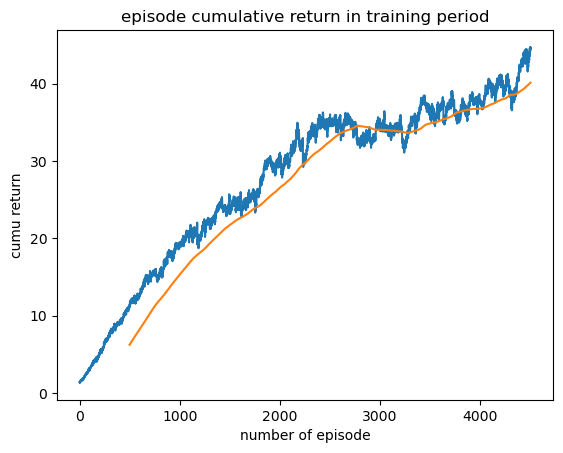

In [8]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
name = []
cumu_return = []
count = 0
for root,_,files in os.walk('./train_history/cumulative_return'):
    for i in files:
        if i.endswith('csv') and 'checkpoint' not in i:
            name.append(i)   
            
name.sort()
for i in name[:-1]:
    count+=1
    tmp = pd.read_csv(os.path.join('./train_history/cumulative_return',i))
    cumu_return.append(tmp['0'].values[-1])
            
print('total episode:',count)
ma = pd.DataFrame(cumu_return).rolling(500).mean()
plt.title('episode cumulative return in training period')
plt.ylabel('cumu return')
plt.xlabel('number of episode')
plt.plot(cumu_return)
plt.plot(ma)
plt.show()

### plot training result

In [9]:
import os
root = './train_history/action/'
action = os.listdir(root)[-1]
df = pd.read_csv(os.path.join(root,action),index_col=False).iloc[:,1:]
price_array = price_array_train

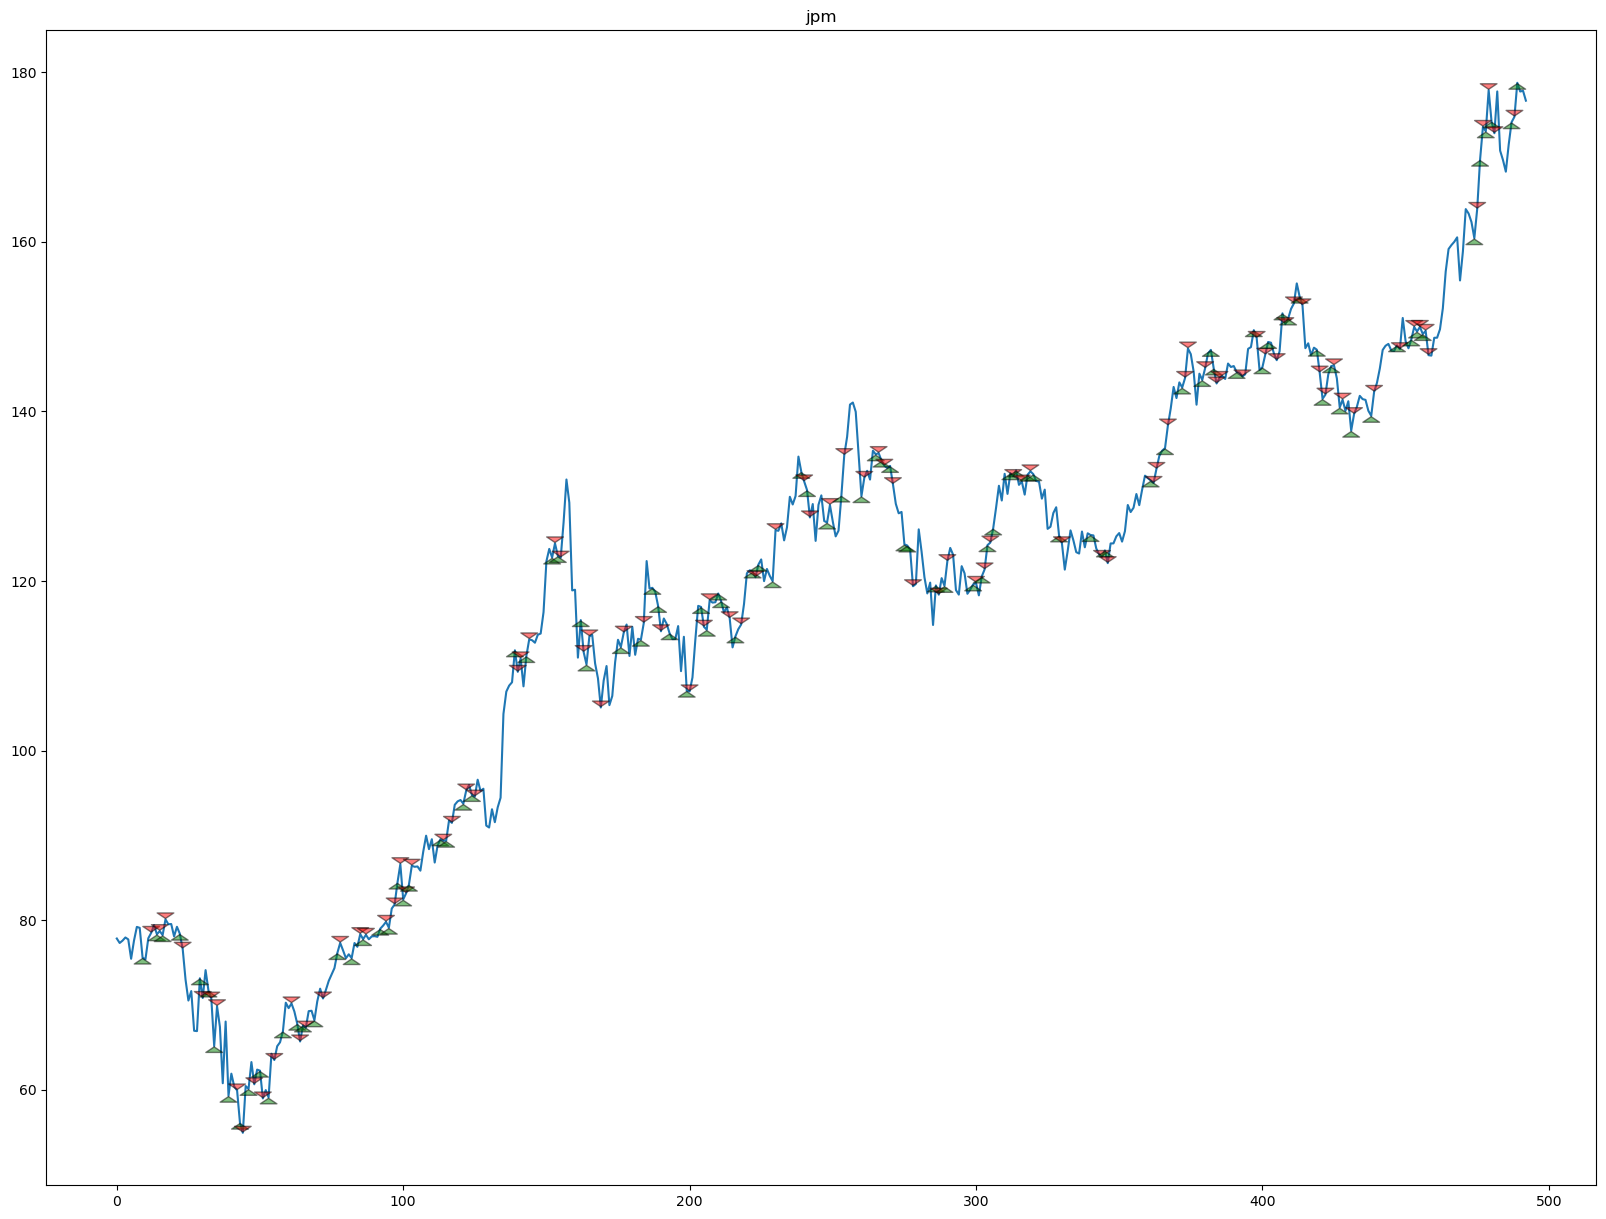

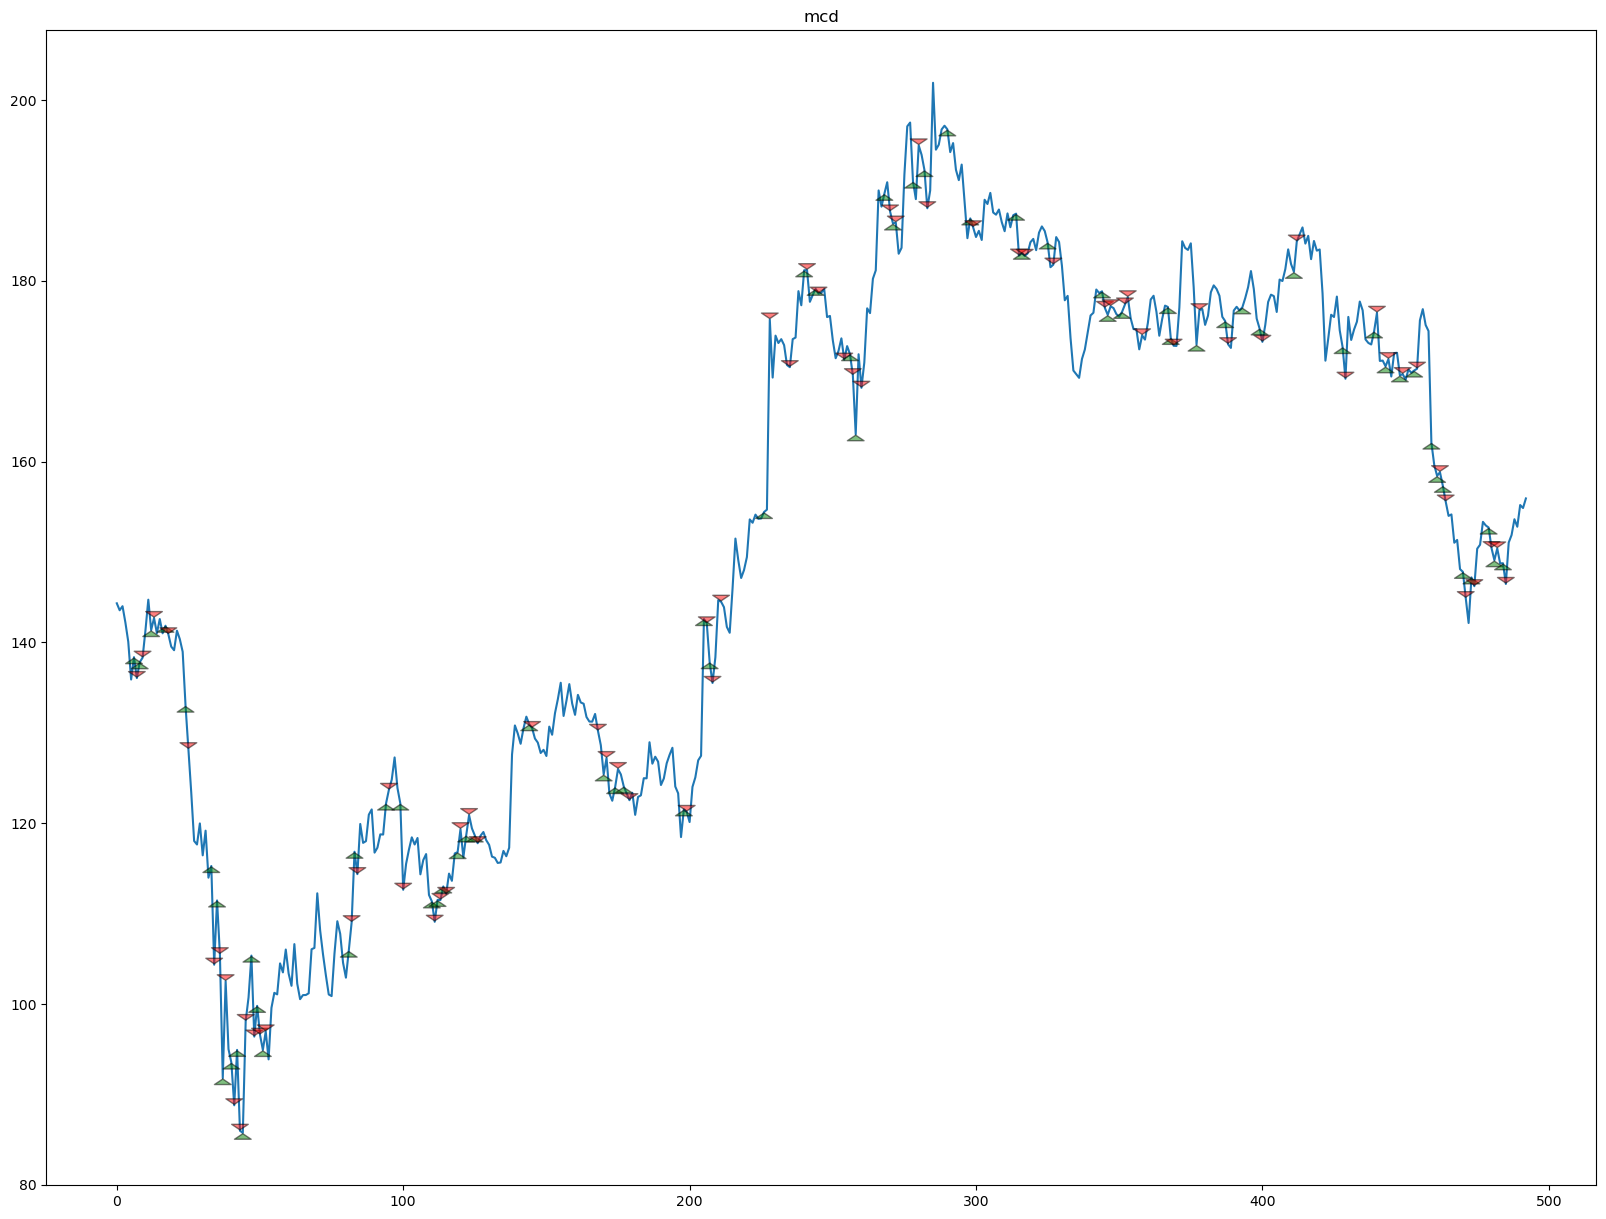

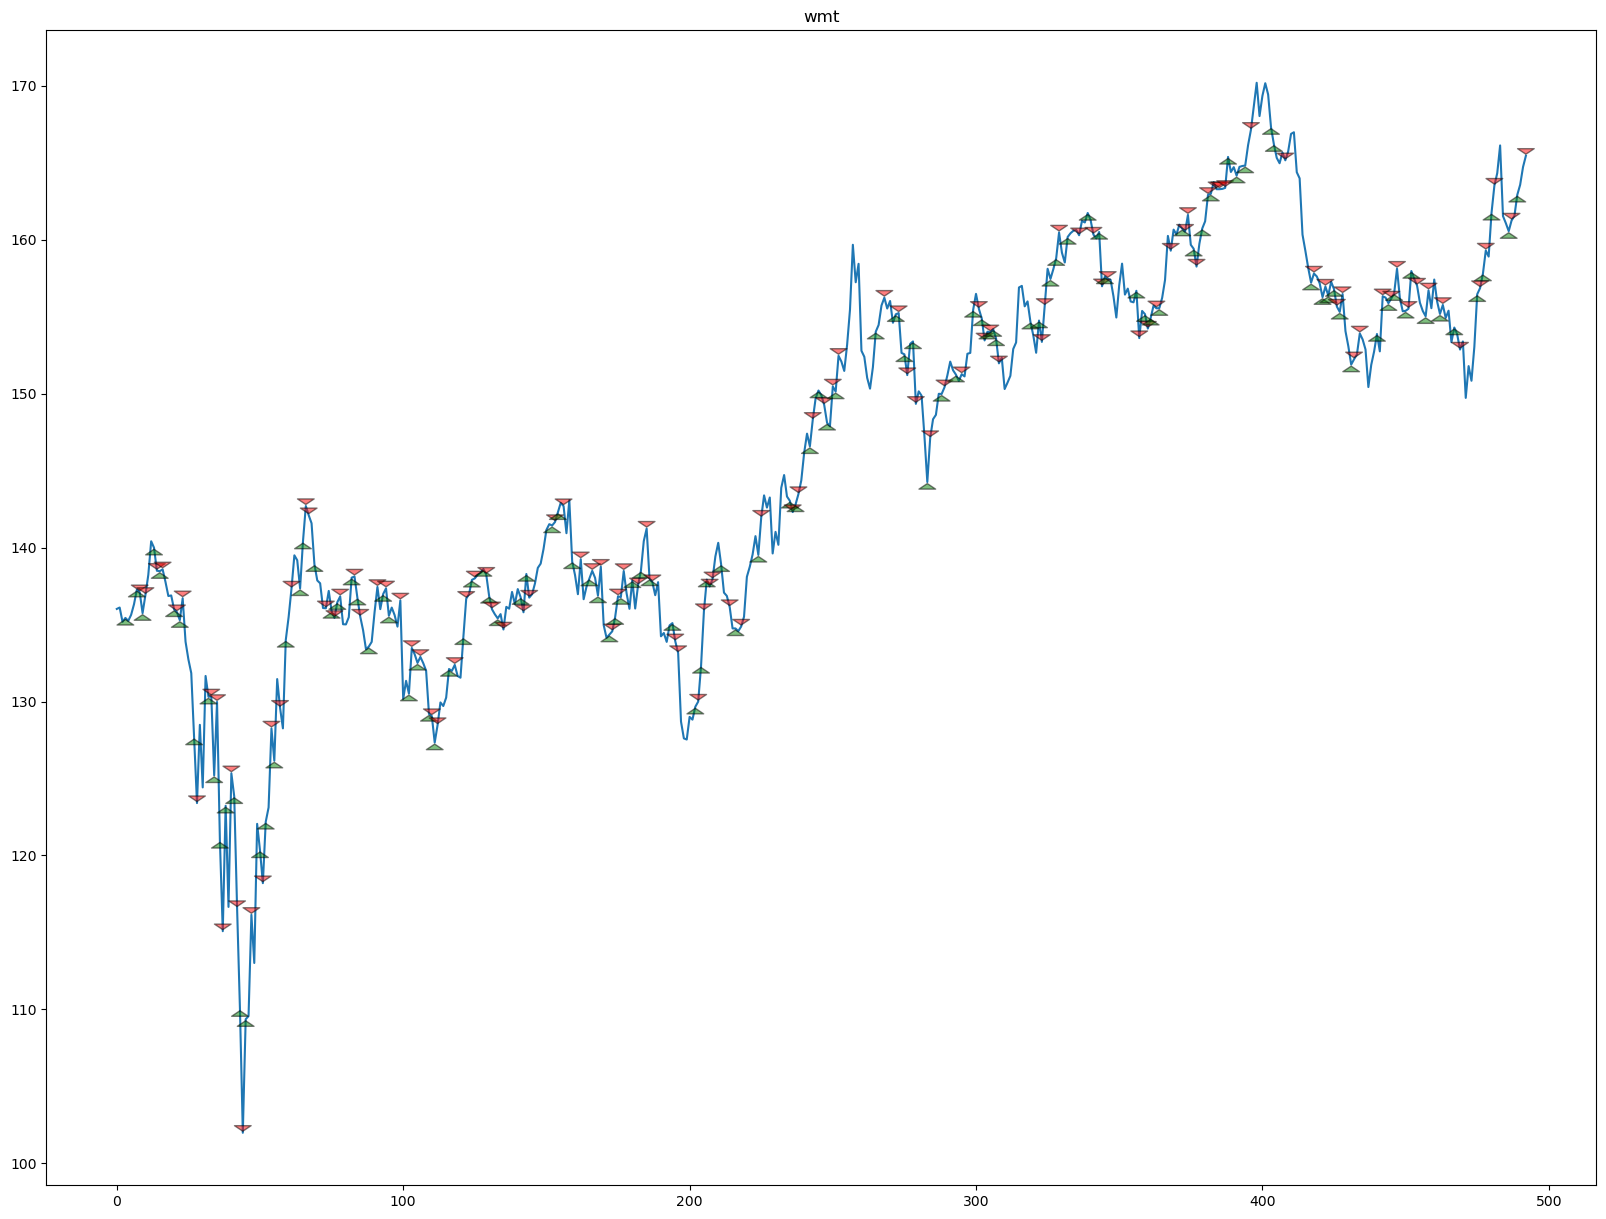

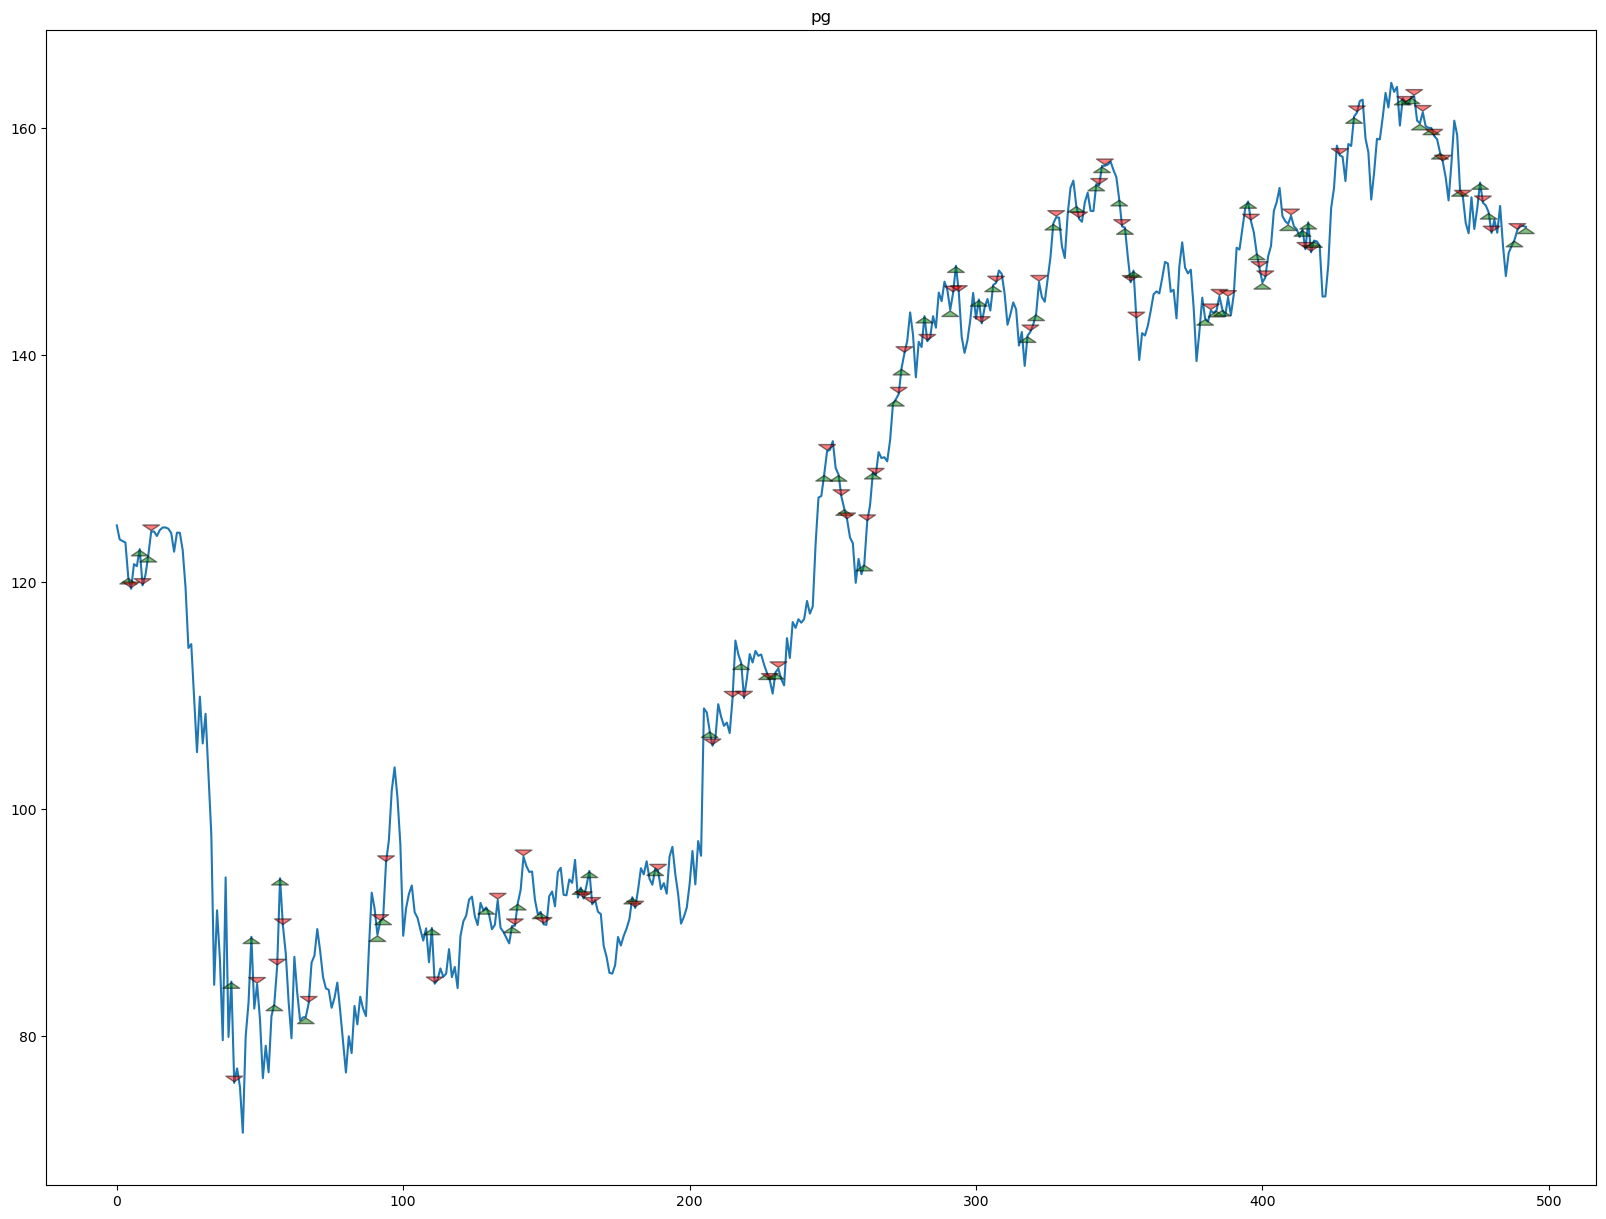

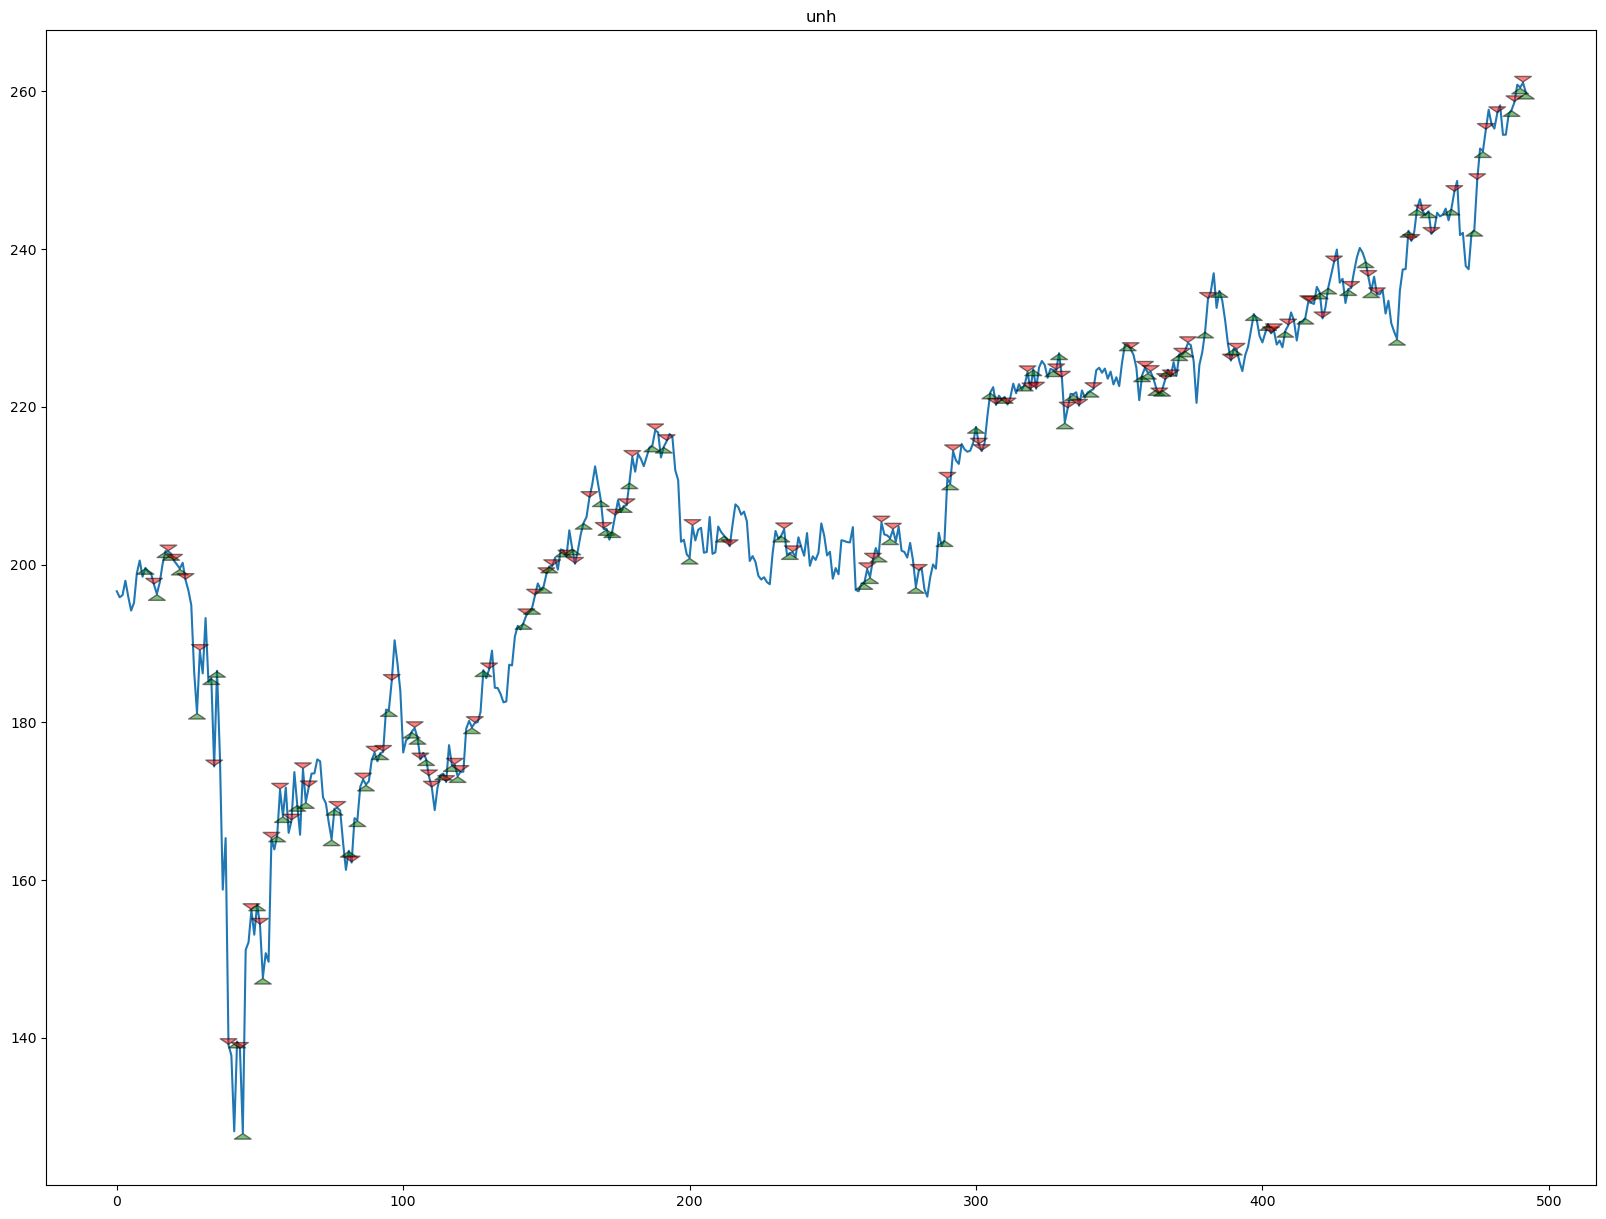

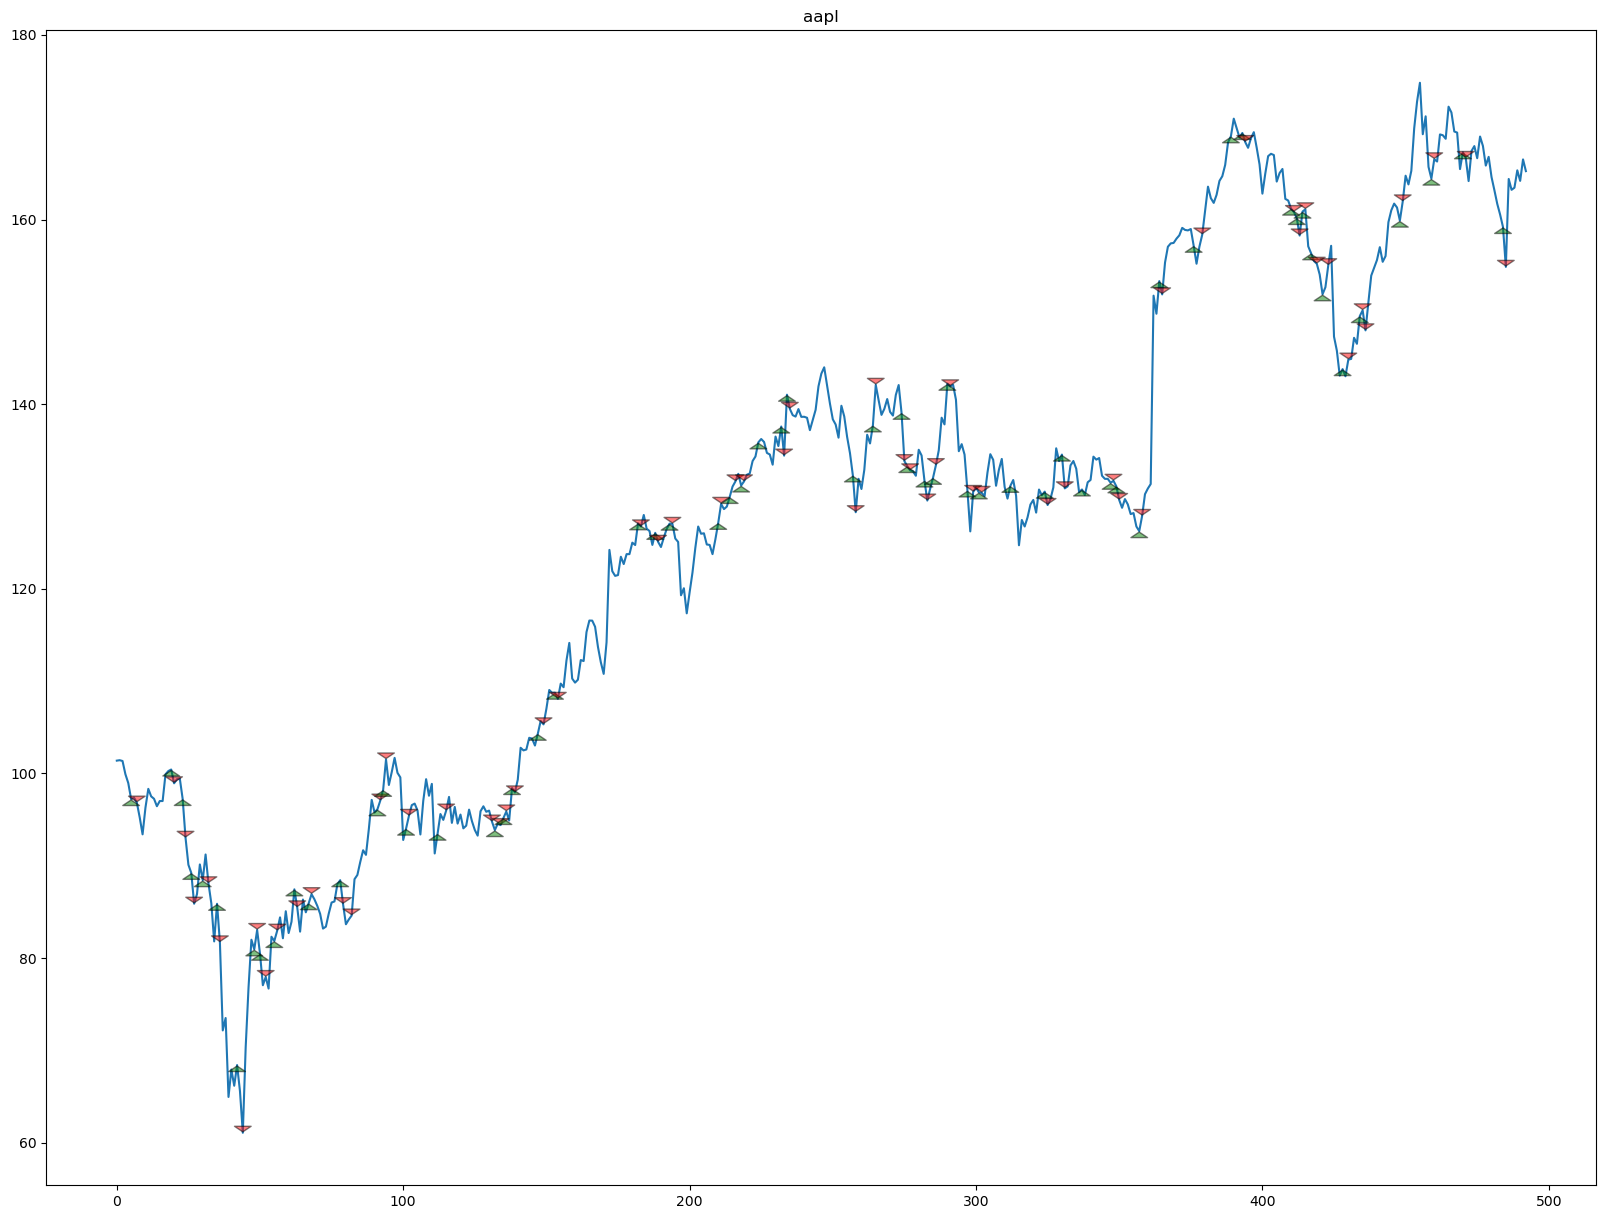

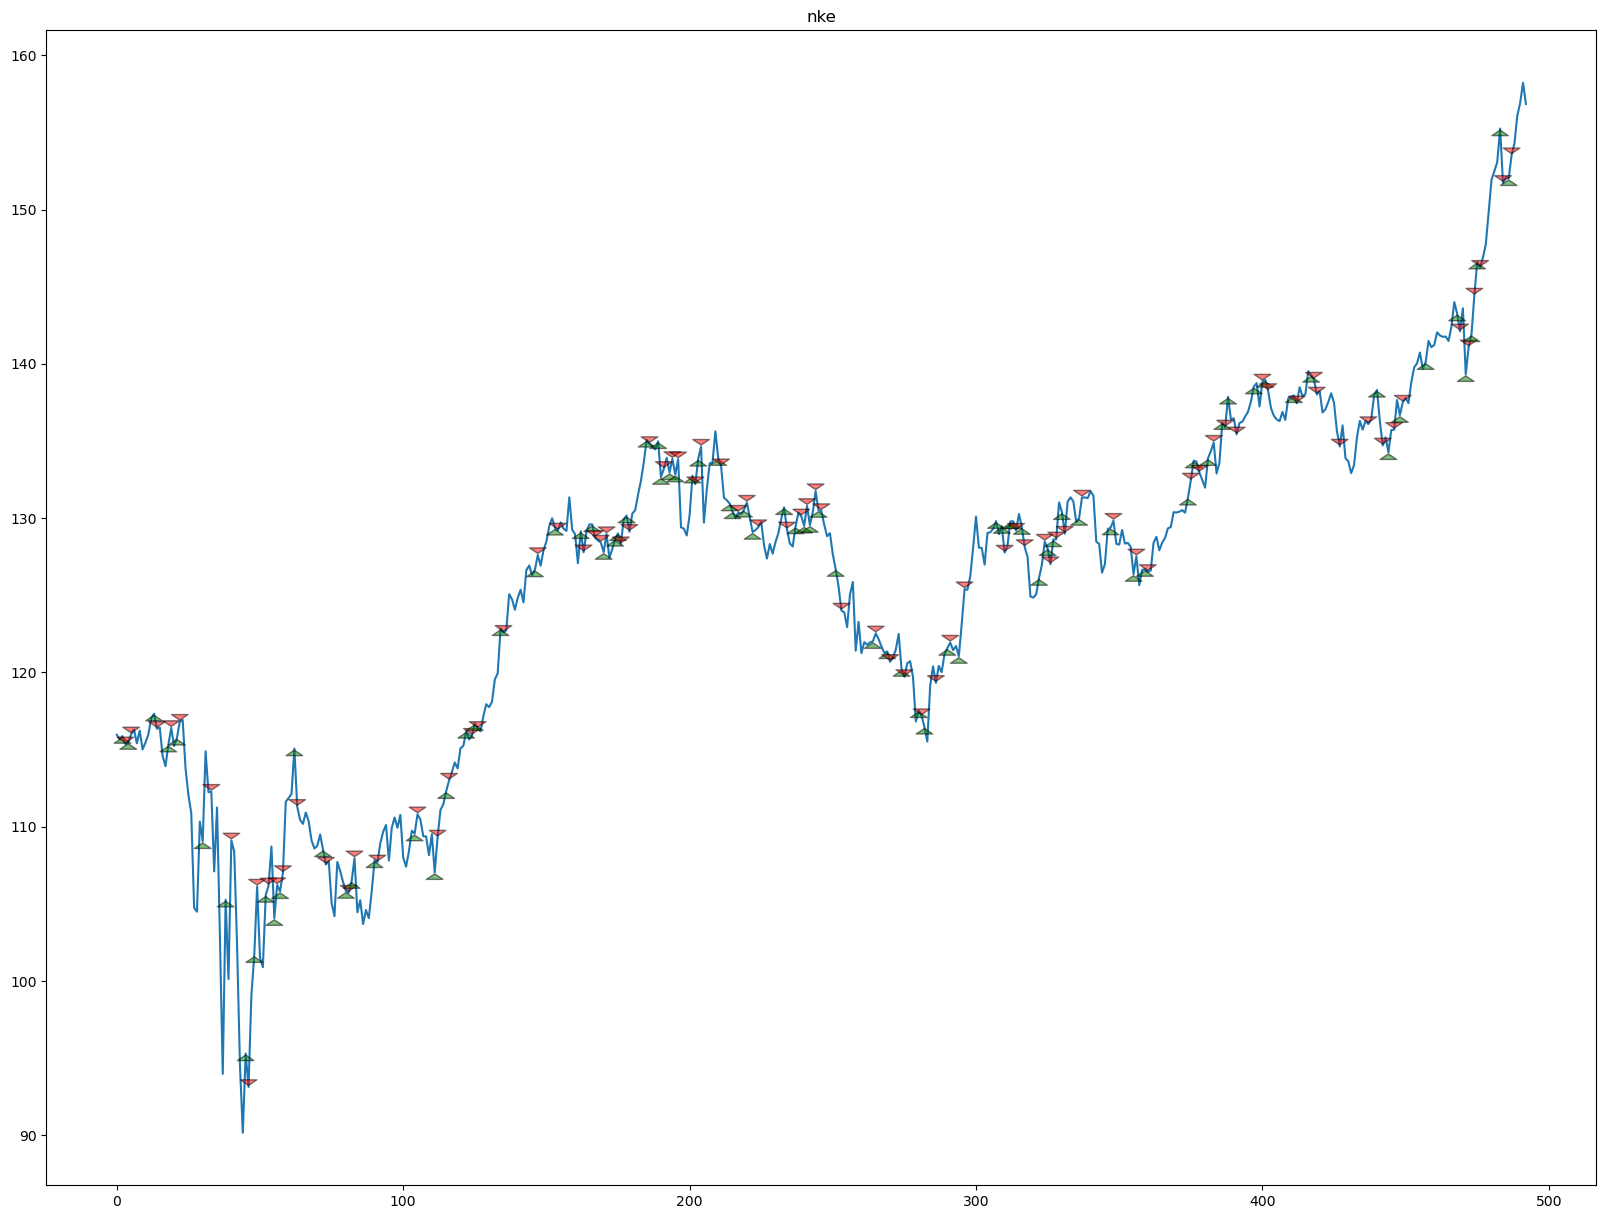

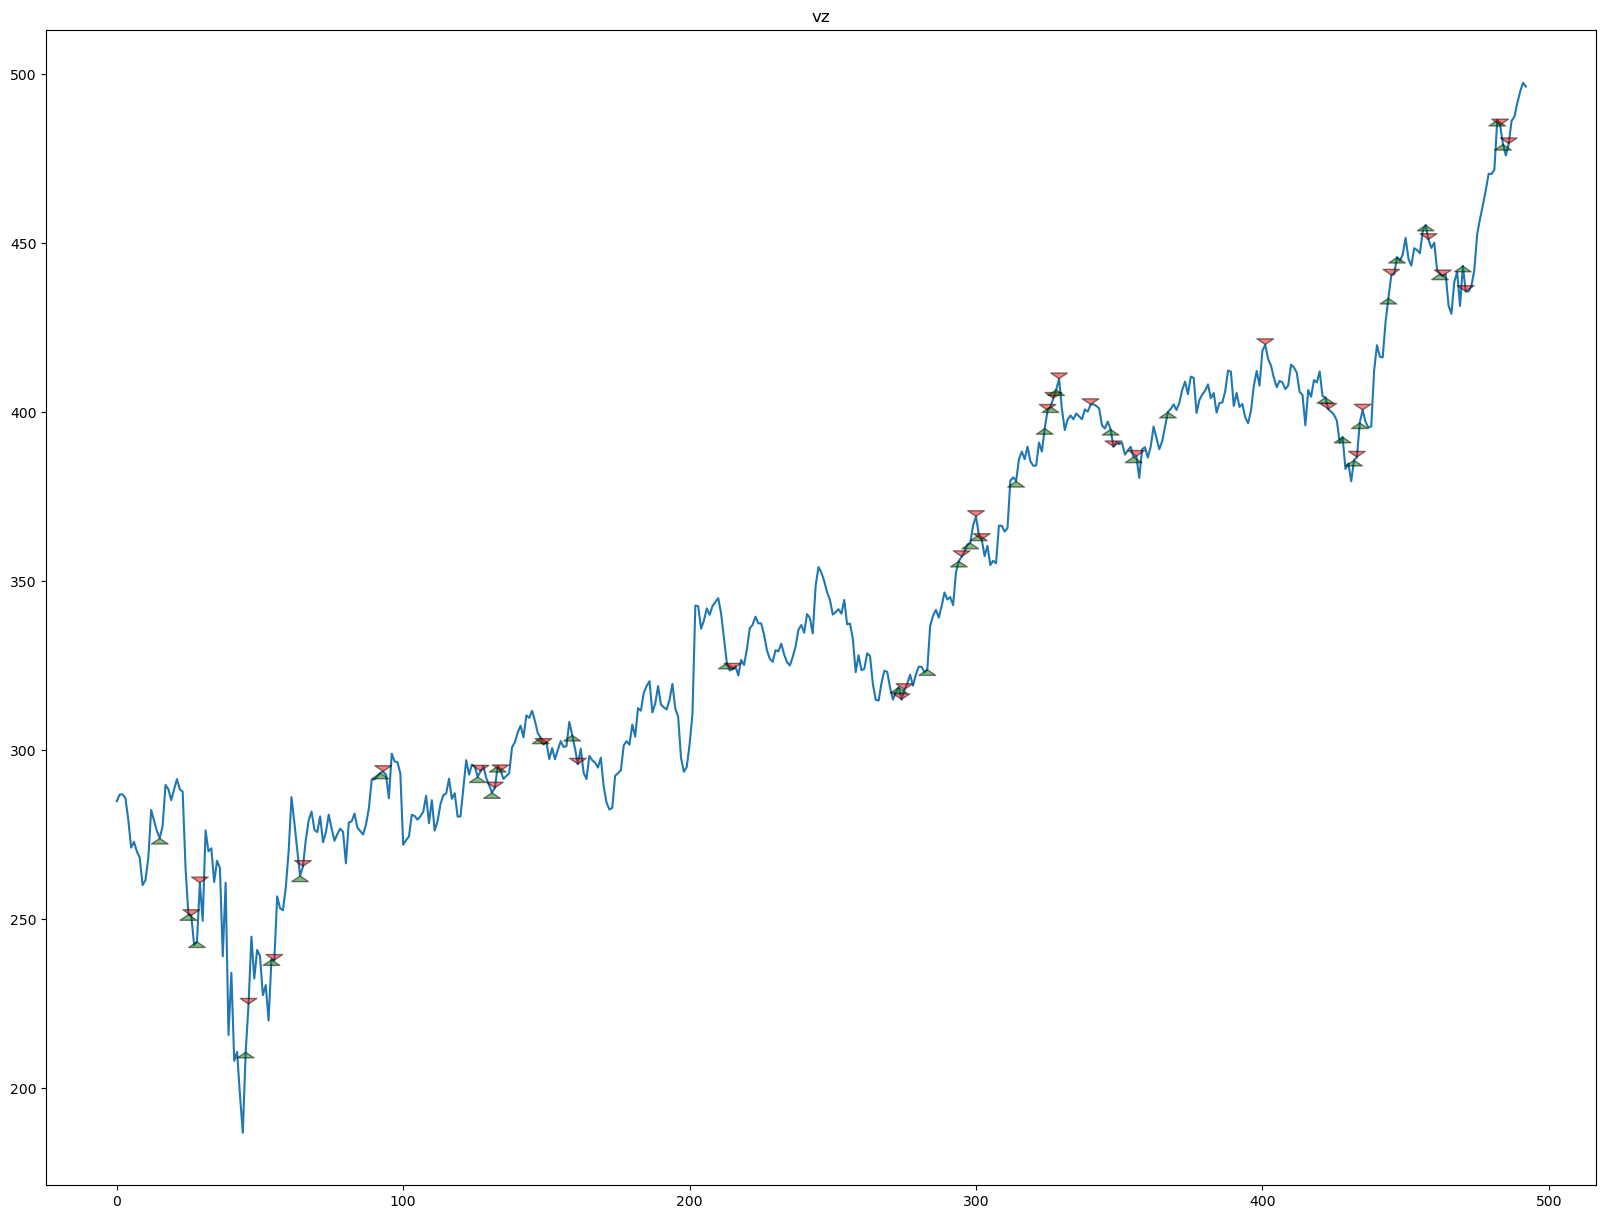

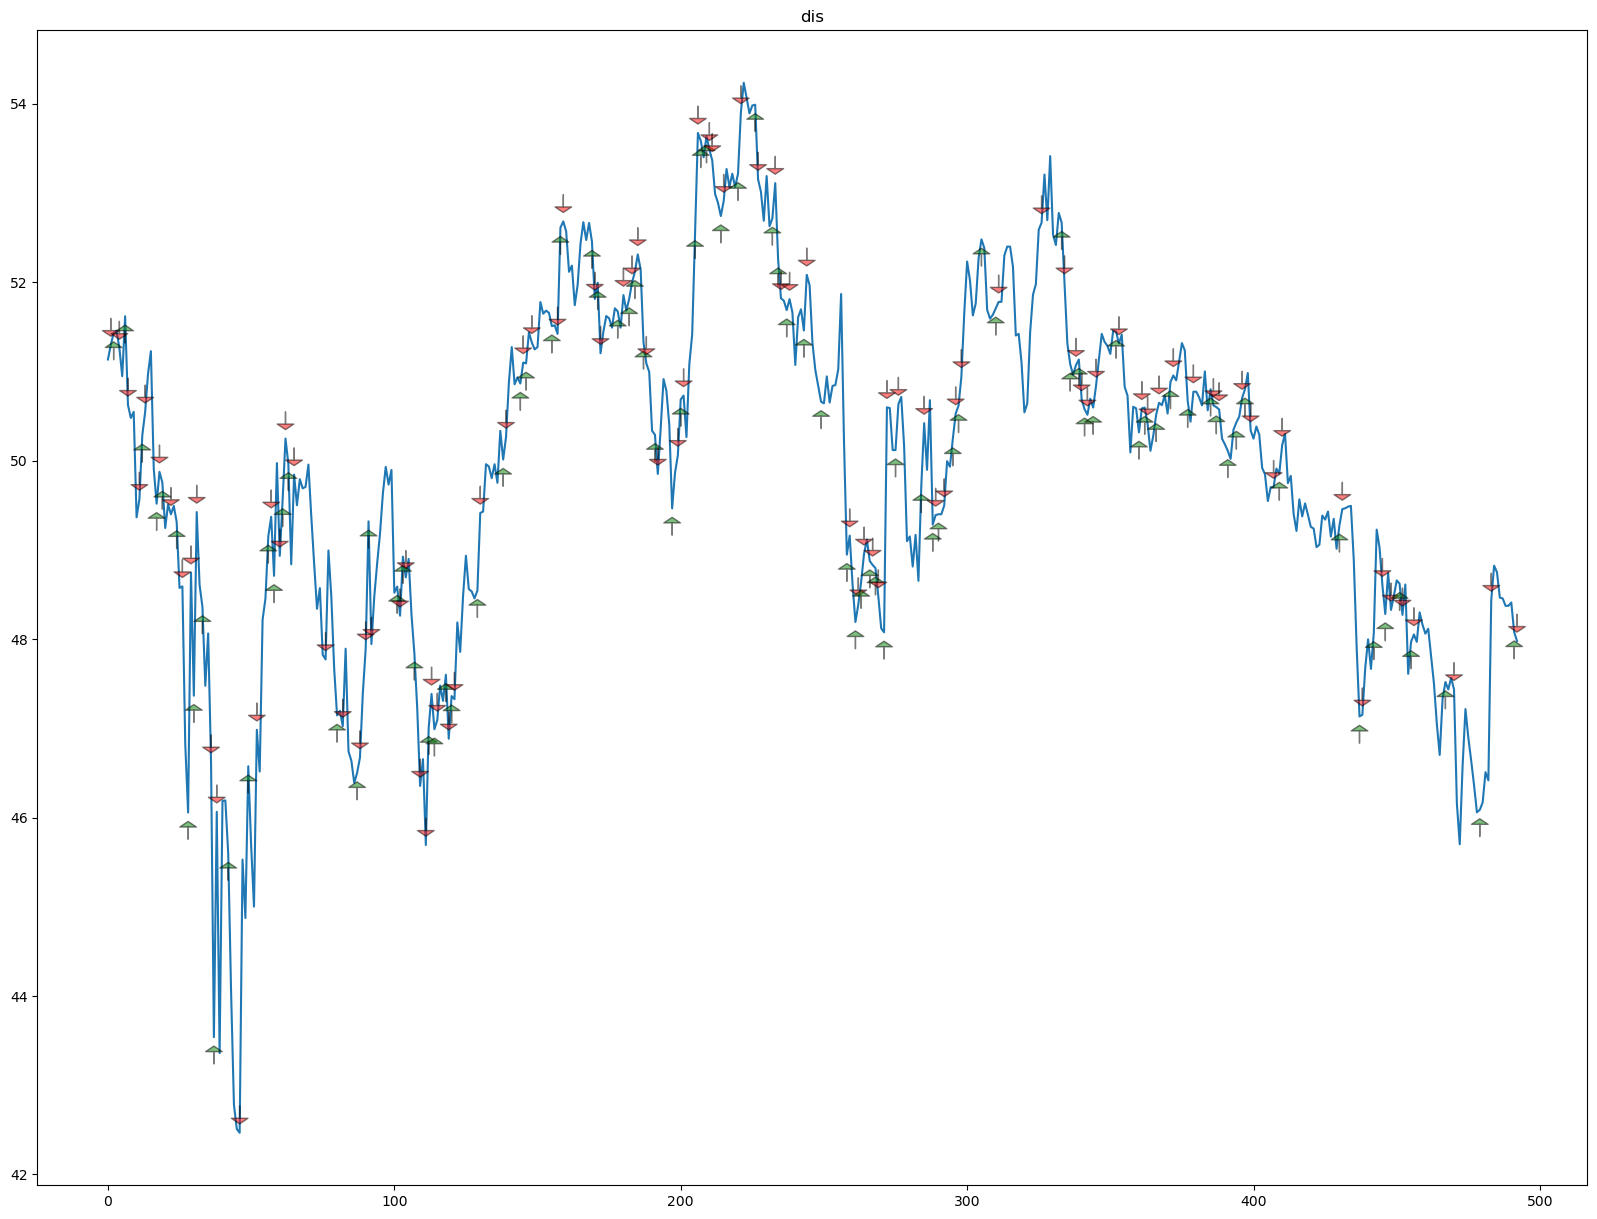

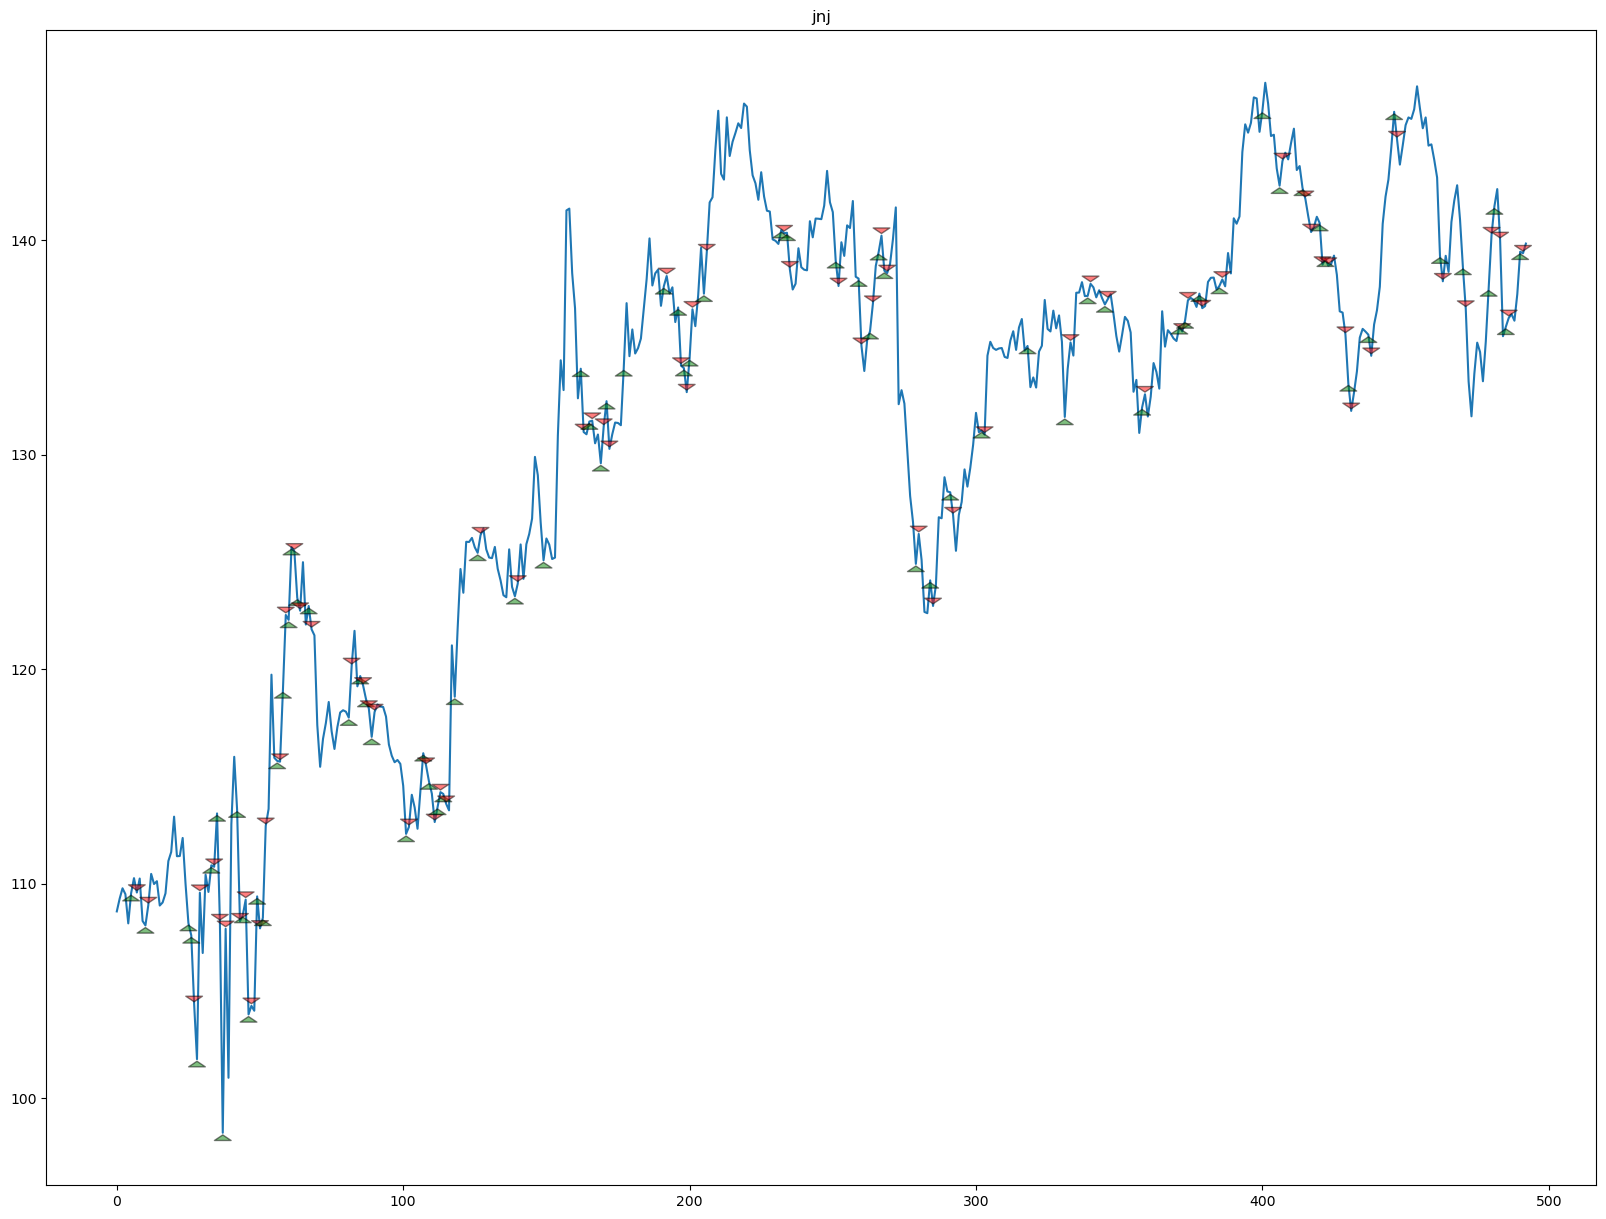

In [10]:
'''
1. df是每個時間點的action(portfolio weight)
2. price_array是每家公司的股價
3. ticker list是每間公司的代號(只是用來顯示在圖片的title而已)
'''

%matplotlib inline
for num,name in enumerate(ticker_list):
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(20)
    ax = fig.add_subplot(111)
    Y = price_array[11:,num]
    X = range(len(Y))
    buy_sig = df.iloc[:,num+1].diff().fillna(0)>0.1  # 大於10%才有箭頭 
    sell_sig = df.iloc[:,num+1].diff().fillna(0)<-0.1
    ax.plot(X,Y)
    for i in X:
        if buy_sig[i]:
            #print('buy')
            ax.annotate("", xy=(i, Y[i]-0.1),xytext=(i, Y[i]-0.3), arrowprops=dict(facecolor="g", alpha=0.5, headlength=4, width=0.1)) 
        elif sell_sig[i]:
            #print('sell')
            ax.annotate("", xy=(i, Y[i]+0.1),xytext=(i, Y[i]+0.3),arrowprops=dict(facecolor="r", alpha=0.5, headlength=4, width=0.1)) 
    plt.title(name)
    plt.show()


### BackTest



In [11]:
len(price_array_test)

251

In [12]:
UBAH_return = (price_array_test[-1,:]-price_array_test[10,:])/price_array_test[10,:]
print(UBAH_return.mean())

-0.08756588933399324


## UBAH

In [13]:
ubah = ((pd.DataFrame(price_array_test).pct_change()*5/6).fillna(0)+1)
ubah = ubah.cumprod().mean(axis=1)
ubah.to_csv('./train_history/UBAH_test.csv')

In [14]:
ubah

0      1.000000
1      1.000693
2      0.996851
3      0.992505
4      0.992853
         ...   
246    0.895834
247    0.897000
248    0.887901
249    0.895748
250    0.894351
Length: 251, dtype: float64

In [15]:
ticker_list

['jpm', 'mcd', 'wmt', 'pg', 'unh', 'aapl', 'nke', 'vz', 'dis', 'jnj']

In [16]:
# pd.DataFrame(price_array_test,columns=['aapl' 'amt' 'amzn' 'brk-a' 'dis' 'jnj' 'lin' 'mmm' 'nee' 'wmt' 'xom'])

In [17]:
x = pd.DataFrame(price_array_test).pct_change().fillna(0)+1
np.mean(np.cumprod(x),axis=1)

0      1.000000
1      1.000831
2      0.996212
3      0.991024
4      0.991486
         ...   
246    0.873509
247    0.874933
248    0.864461
249    0.873338
250    0.871659
Length: 251, dtype: float64

In [18]:
price_array_test[-1,:]

array([129.55271912,  86.87999725, 174.07511902, 132.08015442,
       262.0171814 , 116.67731476, 149.67778015, 528.29833984,
        38.15867233, 140.67683411])

In [19]:
for i in range(1,len(price_array_test.shape[0])):
    price_array_test[i]

TypeError: object of type 'int' has no len()